In [1]:
library(Seurat)
library(tidyverse)

Attaching SeuratObject

Registered S3 method overwritten by 'cli':
  method     from         
  print.boxx spatstat.geom

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.4     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [3]:
gene_mtx_file = "/Personal/fuxin/dfuxin/Github_repo/dev/Pacbio_Analysis/notebooks/data/11.annotation/gene_seurat"
isoform_mtx_file = "/Personal/fuxin/dfuxin/Github_repo/dev/Pacbio_Analysis/notebooks/data/11.annotation/isoforms_seurat"

In [4]:
gene_mtx = Read10X(gene_mtx_file,gene.column = 1)
isoform_mtx = Read10X(isoform_mtx_file,gene.column = 1)

In [5]:
gene_mtx[,df_oa6$barcode_1]->gene_mtx_flt
isoform_mtx[,df_oa6$barcode_1]->isoform_mtx_flt

In [8]:
sob_gene = CreateSeuratObject(gene_mtx_flt,min.cells = 5, min.features = 10)
sob_gene = run_standard(sob_gene)

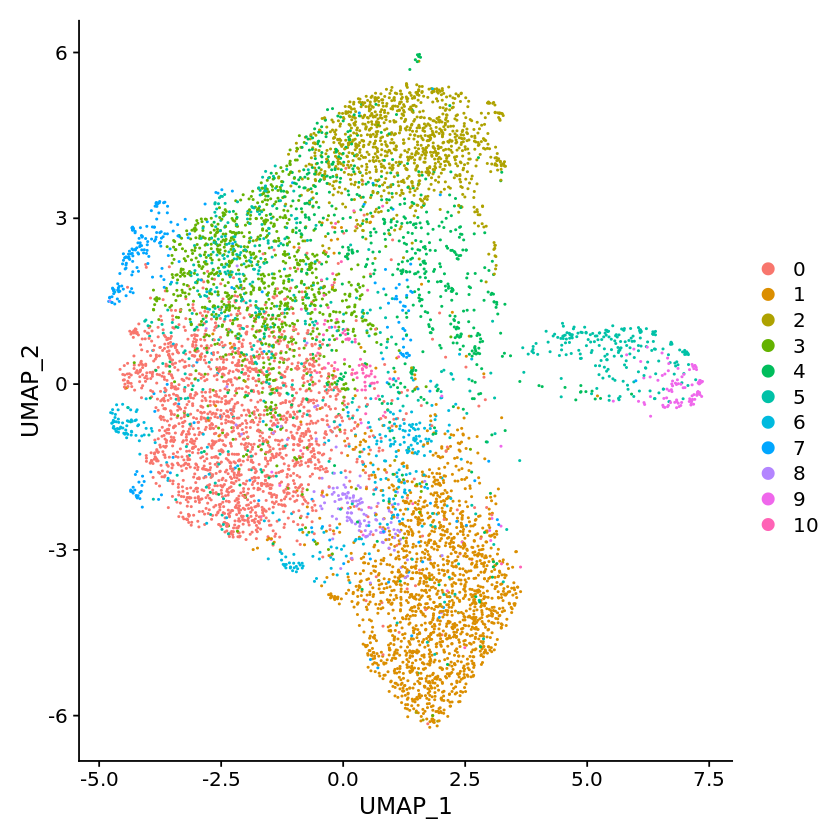

In [27]:
DimPlot(sob_gene,reduction = "umap")

In [33]:
celltype_anno_file = "data/celltype_anno.csv"
celltype_anno_df = readr::read_csv(celltype_anno_file)
celltype_anno_df%>%select(celltype)%>%as.data.frame()->ct_df
rownames(ct_df) <- celltype_anno_df$barcode
head(ct_df)


── Column specification ────────────────────────────────────────────────────────
cols(
  sample = col_character(),
  barcode = col_character(),
  celltype = col_character()
)




,celltype
,<chr>
AAACATCGAACGTGATCTGAGCCA-1,SSCs
AAACATCGGGAGAACACCAGTTCA-1,SSCs
AACAACCAAATGTTGCACGCTCGA-1,SSCs
AACAACCAAGAGTCAAATCCTGTA-1,SSCs
AACCGAGAAGCACCTCCTCAATGA-1,SSCs
AACCGAGAGACAGTGCCCGACAAC-1,SSCs


In [30]:
AddMetaData(sob_gene,ct_df)->sob_gene

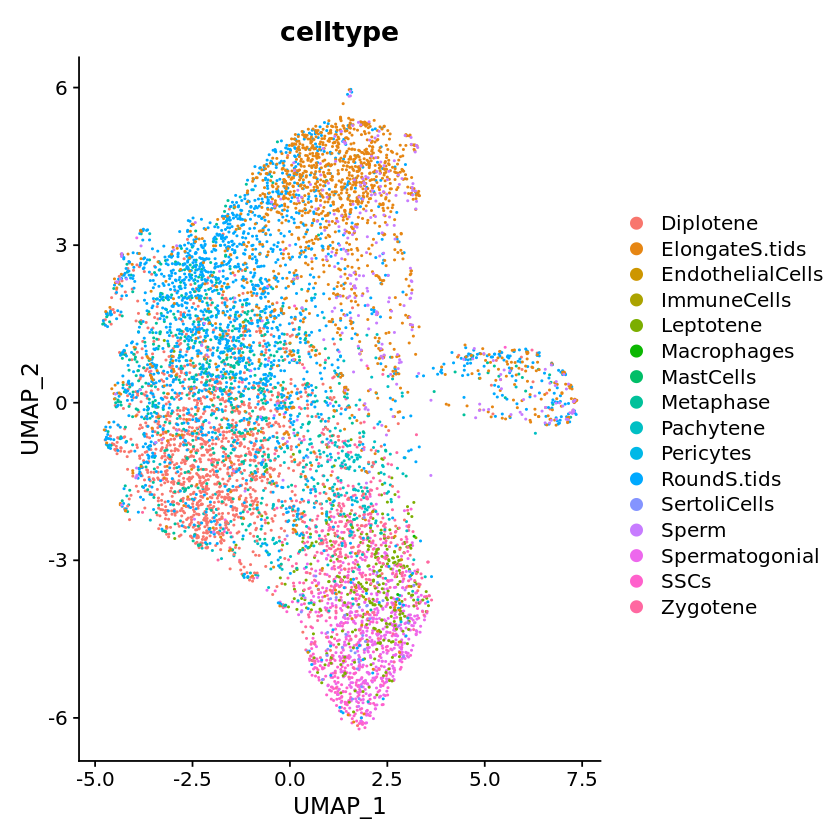

In [31]:
DimPlot(sob_gene,reduction = "umap",group.by = "celltype")

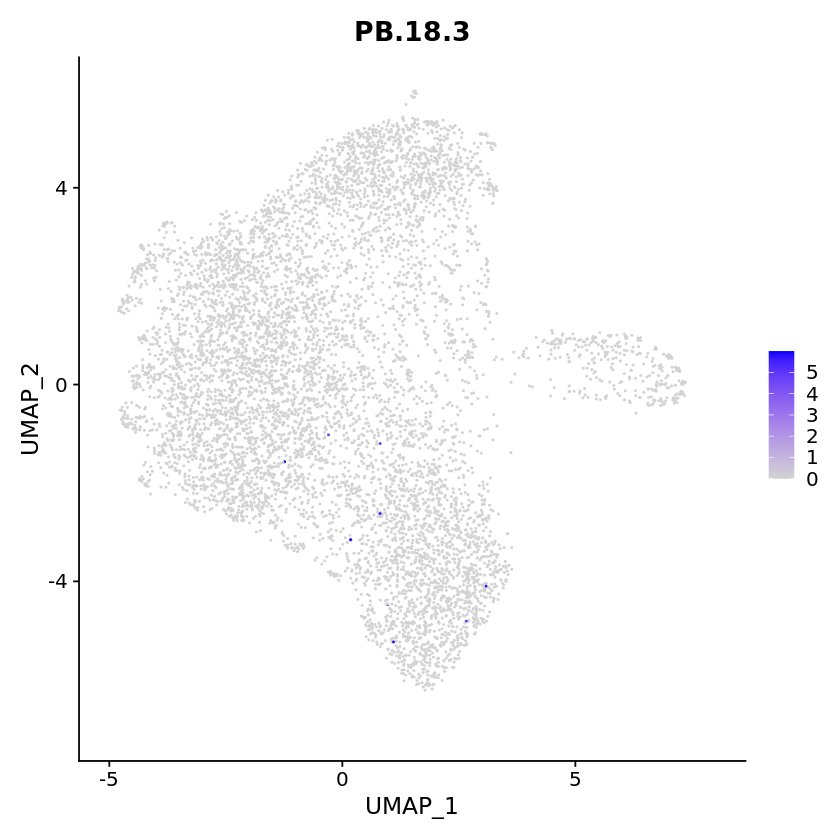

In [79]:
FeaturePlot(sob_gene,features = c("PB.18.3"))

In [47]:
gene_symbol_df = readr::read_tsv("/Personal/fuxin/dfuxin/Bioinfo_Scrs/Y2023/Gene_name/hgnc_complete_set.txt")
gene_anno_df = readr::read_tsv("data/gene_seurat/genes.tsv",
                               col_names = FALSE)


── Column specification ────────────────────────────────────────────────────────
cols(
  X1 = col_character(),
  X2 = col_character()
)




In [62]:
gene_symbol_df%>%
    select(symbol,ensembl_gene_id)%>%
    unique()%>%
    data.frame()%>%
    right_join(gene_anno_df, by = c("ensembl_gene_id" = "X2"))%>%
    filter(!is.na(symbol))->gs_flt
head(gs_flt)

,symbol,ensembl_gene_id,X1
,<chr>,<chr>,<chr>
1,A2M,ENSG00000175899,PB.9924.1
2,A2M,ENSG00000175899,PB.9924.3
3,A2ML1,ENSG00000166535,PB.9909.2
4,AAAS,ENSG00000094914,PB.10691.1
5,AACS,ENSG00000081760,PB.12136.1
6,AACS,ENSG00000081760,PB.12136.7


In [52]:
mtx = sob_gene@assays$RNA@counts

In [60]:
#Time consuming
apply(mtx,2,function(.df){
    data.frame(.df)->.df1
    .df1%>%mutate(pb_id = rownames(.df1))%>%
        left_join(gs_flt,by = c("pb_id" = "X1"))%>%
        filter(!is.na(symbol))%>%
        group_by(symbol)%>%
        summarise(exp = sum(.df))%>%
        ungroup()%>%
        as.data.frame()->.df2
    rownames(.df2) <- .df2$symbol
    return(.df2["exp"])
})->mtx_1

In [68]:
mtx_2 = data.frame(row.names = row.names(mtx_1[[1]]))
for (cell in names(mtx_1)){
        mtx_1[[cell]]->df_tmp
        colnames(df_tmp) <- cell
        mtx_2 <- cbind(mtx_2,df_tmp)
}

In [69]:
mtx_3 = as.matrix(mtx_2,"dgTMatrix")

In [ ]:
sob_gene_symbol = CreateSeuratObject(mtx_3,min.cells = 5, min.features = 10)
sob_gene_symbol = run_standard(sob_gene_symbol)

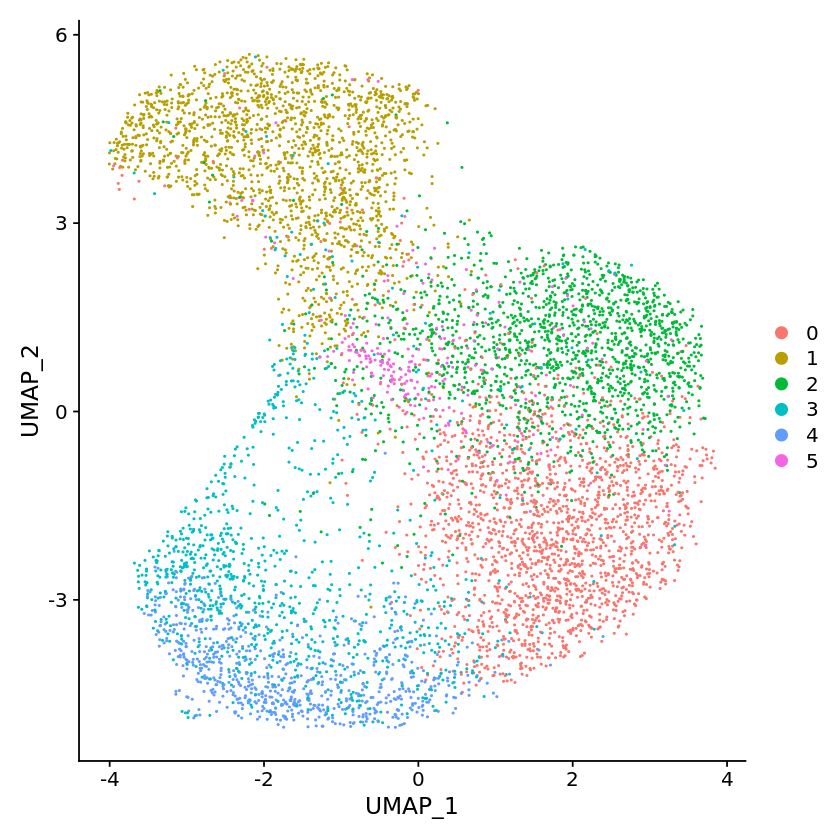

In [73]:
DimPlot(sob_gene_symbol,reduction = "umap")

In [74]:
AddMetaData(sob_gene_symbol,ct_df)->sob_gene_symbol

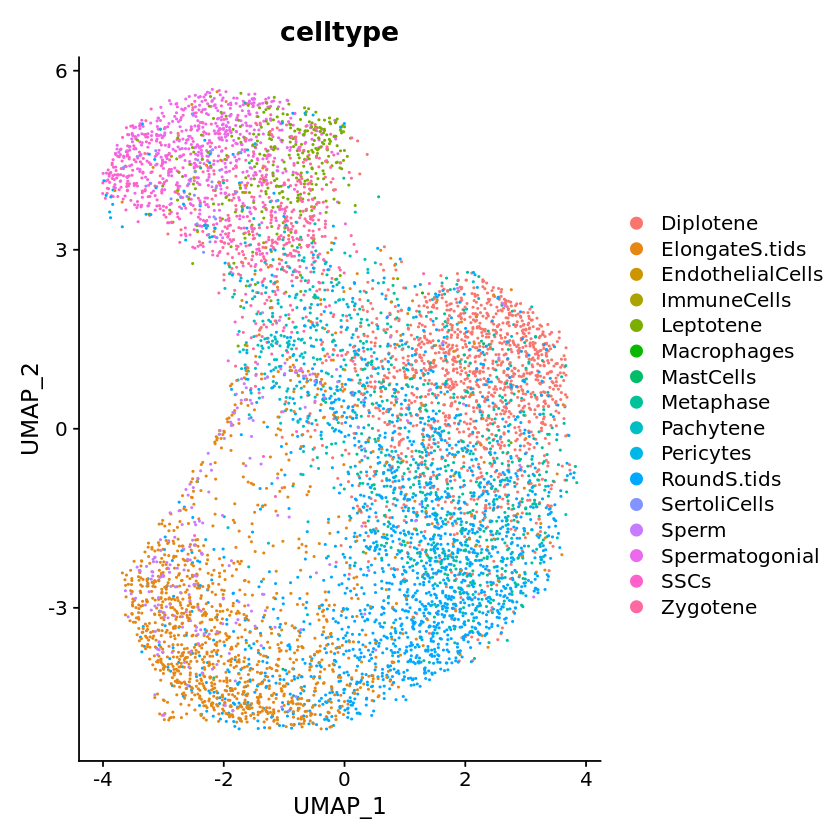

In [75]:
DimPlot(sob_gene_symbol,reduction = "umap",group.by = "celltype")

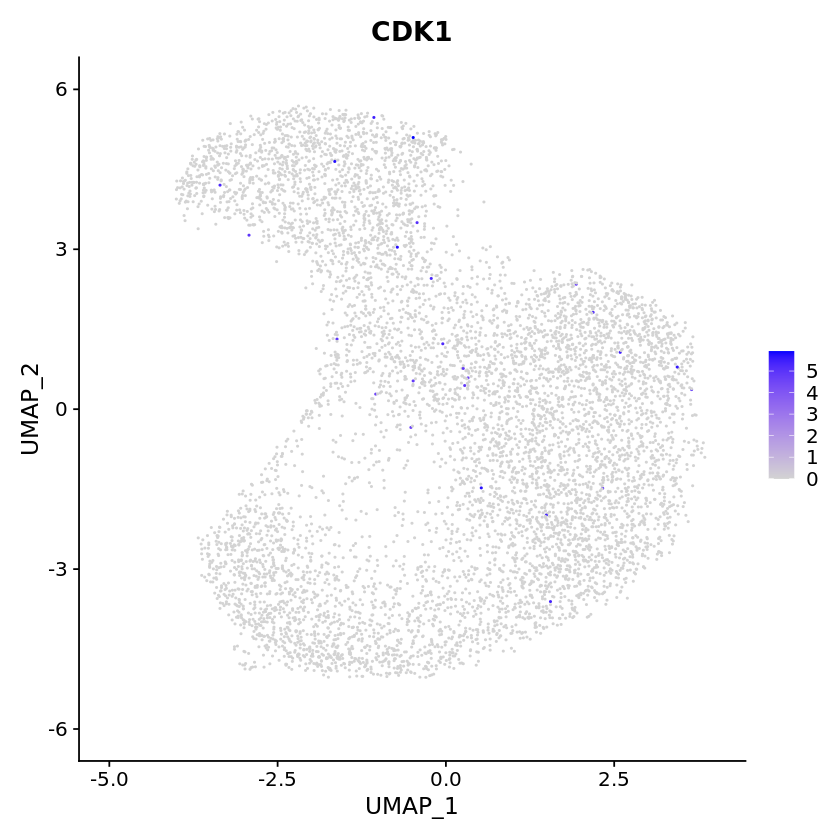

In [78]:
FeaturePlot(sob_gene_symbol,features = c("CDK1"))

In [24]:
#---functions----------
run_standard <- function(rds,nfeatures=2000,Dims =20, resolution=0.6){
    #Normalize& Findvar
    nfeatures = nfeatures
    rds <- NormalizeData(rds, normalization.method = "LogNormalize",scale.factor = 10000)
    rds <- FindVariableFeatures(rds, selection.method = "vst", nfeatures = nfeatures, mean.cutoff = c(0.1, 8), 
                                dispersion.cutoff = c(1, Inf),
                                mean.function = ExpMean, dispersion.function = LogVMR)
    #scale
    use.genes <- rds@assays$RNA@var.features
    rds <- ScaleData(rds, vars.to.regress = c("nCount_RNA","percent.mito"), features = use.genes) #no percent.mito
    #library(harmony)
    rds <- RunPCA(object = rds, features = use.genes, do.print = FALSE)
    #rds_M <- RunHarmony(rds_M, group.by.vars = "orig.ident")
    #降维聚类
    rds <- FindNeighbors(rds, dims = 1:Dims, force.recalc = TRUE, reduction = "pca")
    rds <- FindClusters(rds, resolution = resolution)
    # TSNE& UMAP
    rds <- RunTSNE(rds, dims = 1:Dims,check_duplicates = FALSE)
    rds <- RunUMAP(rds, dims=1:Dims)

    return(rds)
}